In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import warnings
import matplotlib.cbook

warnings.filterwarnings(action='ignore', message='Mean of empty slice')

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
plt.rcParams["font.family"] = "Times New Roman"

/var/folders/5r/qv7l_8js1q14w4c0mg43lz7m0000gn/T/ipykernel_89872/183952466.py:9: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [2]:
import glob
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr
from scipy.interpolate import make_interp_spline
from scipy.stats import linregress
import xarray as xr
import seaborn as sns
import netCDF4 as nc
from netCDF4 import Dataset

In [3]:
# Plot Data
import os
import cartopy
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.patches as mpatches

# Read Data

### Read ERA5

In [4]:
# ERA5: Wave, Wind

data_wave = xr.open_dataset('../Data/Reanalysis ERA5/significant wave height and wave direction.nc')
data_wind = xr.open_dataset('../Data/Reanalysis ERA5/adaptor.mars.internal-1681389580.6407816-10423-5-892aa765-336e-445a-b8fd-b84614bb4bb4.nc')

# Date
date_wind = pd.date_range('2000-01-01 00:00:00', '2022-12-31 23:00:00', freq='1M')
date_wave = pd.date_range('2000-01-01 00:00:00', '2022-12-31 23:00:00', freq='1M')

In [5]:
# Read latitude and longitude
all_latitude_wind = np.array(data_wind['latitude'])
all_longitude_wind = np.array(data_wind['longitude'])
latitude_wind = np.where((all_latitude_wind >= 0) & (all_latitude_wind <= 6))[0]
longitude_wind = np.where((all_longitude_wind >= 96) & (all_longitude_wind <= 104))[0]

all_latitude_wave = np.array(data_wave['latitude'])
all_longitude_wave = np.array(data_wave['longitude'])
latitude_wave = np.where((all_latitude_wave >= 0) & (all_latitude_wave <= 6))[0]
longitude_wave = np.where((all_longitude_wave >= 96) & (all_longitude_wave <= 104))[0]

In [6]:
u = data_wind['u10'][36:132,latitude_wind[0]:latitude_wind[-1]+1,longitude_wind[0]:longitude_wind[-1]+1]
v = data_wind['v10'][36:132,latitude_wind[0]:latitude_wind[-1]+1,longitude_wind[0]:longitude_wind[-1]+1]
ws = data_wind['si10'][36:132,latitude_wind[0]:latitude_wind[-1]+1,longitude_wind[0]:longitude_wind[-1]+1]

wave_direction = data_wave['mwd'][36:132,latitude_wave[0]:latitude_wave[-1]+1,longitude_wave[0]:longitude_wave[-1]+1]
significant_wave_height = data_wave['swh'][36:132,latitude_wave[0]:latitude_wave[-1]+1,longitude_wave[0]:longitude_wave[-1]+1]

u.shape, v.shape, ws.shape, wave_direction.shape, significant_wave_height.shape

((96, 25, 33), (96, 25, 33), (96, 25, 33), (96, 13, 17), (96, 13, 17))

# Monthly and Yearly Dataset

In [7]:
# Monthly Data

monthly_data = {'u': u, 'v': v, 'WS': ws, 'WD': wave_direction, 'SWH': significant_wave_height}

In [8]:
# Yearly Dataset

date_year = pd.date_range('2003-01-01', periods=8, freq='1Y')

yearly_data = {}
for variable, data in monthly_data.items():
    yearly_data[variable] = np.empty((8, *data.shape[1:]))
    j = 0
    for i in range(0, 96, 12):
        yearly_data[variable][j, :, :] = np.nanmean(data[i:i+12, :, :], axis=0)
        j += 1

# Climatology Plot

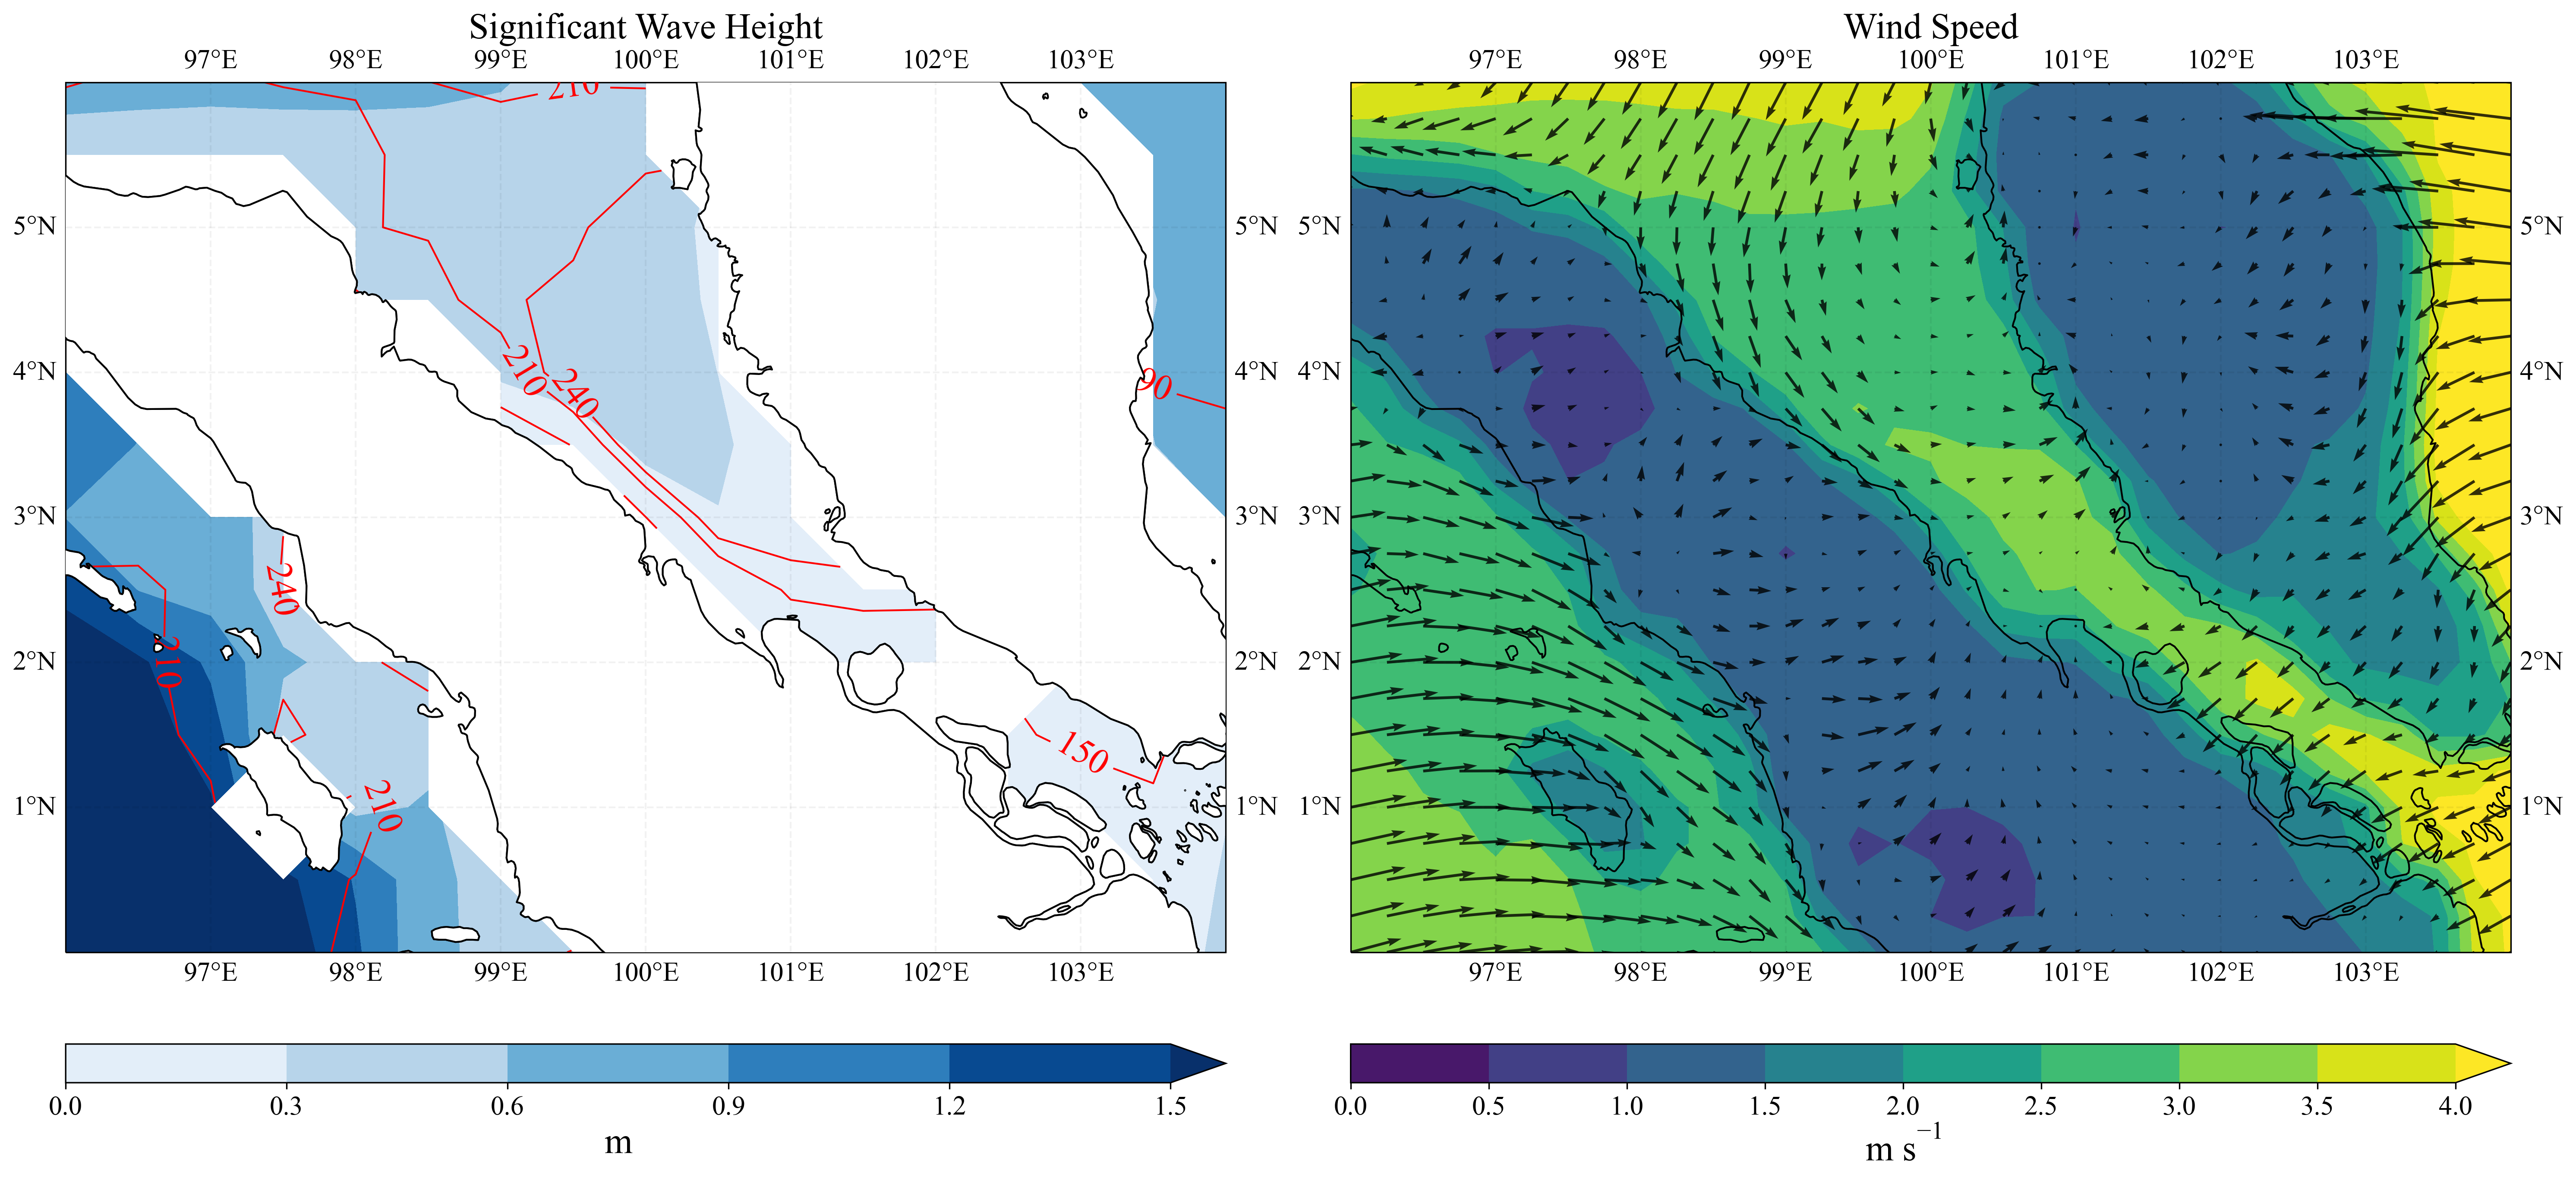

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

parameters = ['SWH', 'WS']
cmaps = ['Blues', 'cool']
levels = [np.arange(0, 1.6, 0.3), np.arange(0,4.5,0.5)]
extensions = ['max', 'max']
titles = ['Significant Wave Height', 'Wind Speed']
labels_unit = ['m', 'm $\mathregular{s^{-1}}$']

lat_lon_data = [[all_longitude_wave, all_latitude_wave, longitude_wave, latitude_wave],
                [all_longitude_wind, all_latitude_wind, longitude_wind, latitude_wind]]

for i, ax in enumerate(axs.flat):
    parameter = parameters[i]
    cmap = plt.get_cmap(cmaps[i]) if cmaps[i] is not None else None
    data = monthly_data[parameter]
    
    if parameter == 'WS':        
        x, y = np.meshgrid(lat_lon_data[i][0][lat_lon_data[i][2][0]:lat_lon_data[i][2][-1]+1], 
                           lat_lon_data[i][1][lat_lon_data[i][3][0]:lat_lon_data[i][3][-1]+1])
        
        cf = ax.contourf(lat_lon_data[i][0][lat_lon_data[i][2][0]:lat_lon_data[i][2][-1]+1], 
                         lat_lon_data[i][1][lat_lon_data[i][3][0]:lat_lon_data[i][3][-1]+1],
                         np.nanmean(monthly_data['WS'], axis=0), levels=levels[i], extend=extensions[i])
        ax.quiver(x[::1, ::1], y[::1, ::1], np.nanmean(monthly_data['u'], axis=0)[::1, ::1], 
                  np.nanmean(monthly_data['v'], axis=0)[::1, ::1], transform=ccrs.PlateCarree(), alpha=0.8)
        cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", fraction=0.046, pad=0.08, aspect=30)
        cbar.set_label(labels_unit[i], fontsize=20)
        cbar.ax.tick_params(labelsize=15)
    
    elif parameter == 'SWH':
        cs = ax.contour(lat_lon_data[i][0][lat_lon_data[i][2][0]:lat_lon_data[i][2][-1]+1], 
                        lat_lon_data[i][1][lat_lon_data[i][3][0]:lat_lon_data[i][3][-1]+1], 
                        np.nanmean(monthly_data['WD'], axis=0), levels=[90, 150, 210, 240], colors='red', 
                        linestyles='-', linewidths=1)
        ax.clabel(cs, fontsize=20)
        cf = ax.contourf(lat_lon_data[i][0][lat_lon_data[i][2][0]:lat_lon_data[i][2][-1]+1], 
                         lat_lon_data[i][1][lat_lon_data[i][3][0]:lat_lon_data[i][3][-1]+1],
                         np.nanmean(monthly_data['SWH'], axis=0), levels=levels[i], extend=extensions[i], cmap=cmap)
        ax.add_feature(cfeature.LAND, zorder=10, edgecolor='k', facecolor='white')
        cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", fraction=0.046, pad=0.08, aspect=30)
        cbar.set_label(labels_unit[i], fontsize=20)
        cbar.ax.tick_params(labelsize=15)
    
    else:
        cf = ax.contourf(lat_lon_data[i][0][lat_lon_data[i][2][0]:lat_lon_data[i][2][-1]+1], 
                         lat_lon_data[i][1][lat_lon_data[i][3][0]:lat_lon_data[i][3][-1]+1],
                         np.nanmean(data, axis=0), levels=levels[i], extend=extensions[i], cmap=cmap)
        ax.add_feature(cfeature.LAND, zorder=10, edgecolor='k', facecolor='white')
        cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", fraction=0.046, pad=0.08, aspect=30)
        cbar.set_label(labels_unit[i], fontsize=20)
        cbar.ax.tick_params(labelsize=15)
        
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(), zorder=200, linewidth=1, color='black', alpha=0.05, linestyle='--',
                      draw_labels=True)
    gl.ylabels_top = False
    gl.xlabels_left = False
    gl.xlabels_right = True
    gl.ylines = True
    gl.ylocator = mticker.FixedLocator(np.arange(-20,20,1))
    gl.xlocator = mticker.FixedLocator(np.arange(90,120,1))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    ax.set_title(titles[i], fontsize=20, color="black")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
# fig.savefig('Climatology Plot.png')

# Time-Series

In [10]:
# Create Monthly Time-series
monthly_dates = pd.date_range(start='2003-01-01', periods=96, freq='M')

# Create monthly time-series for each variable
monthly_time_series = {}
for variable, data in monthly_data.items():
    variable_ts = np.nanmean(data, axis=(1, 2))
    monthly_time_series[variable] = pd.Series(variable_ts, index=monthly_dates)

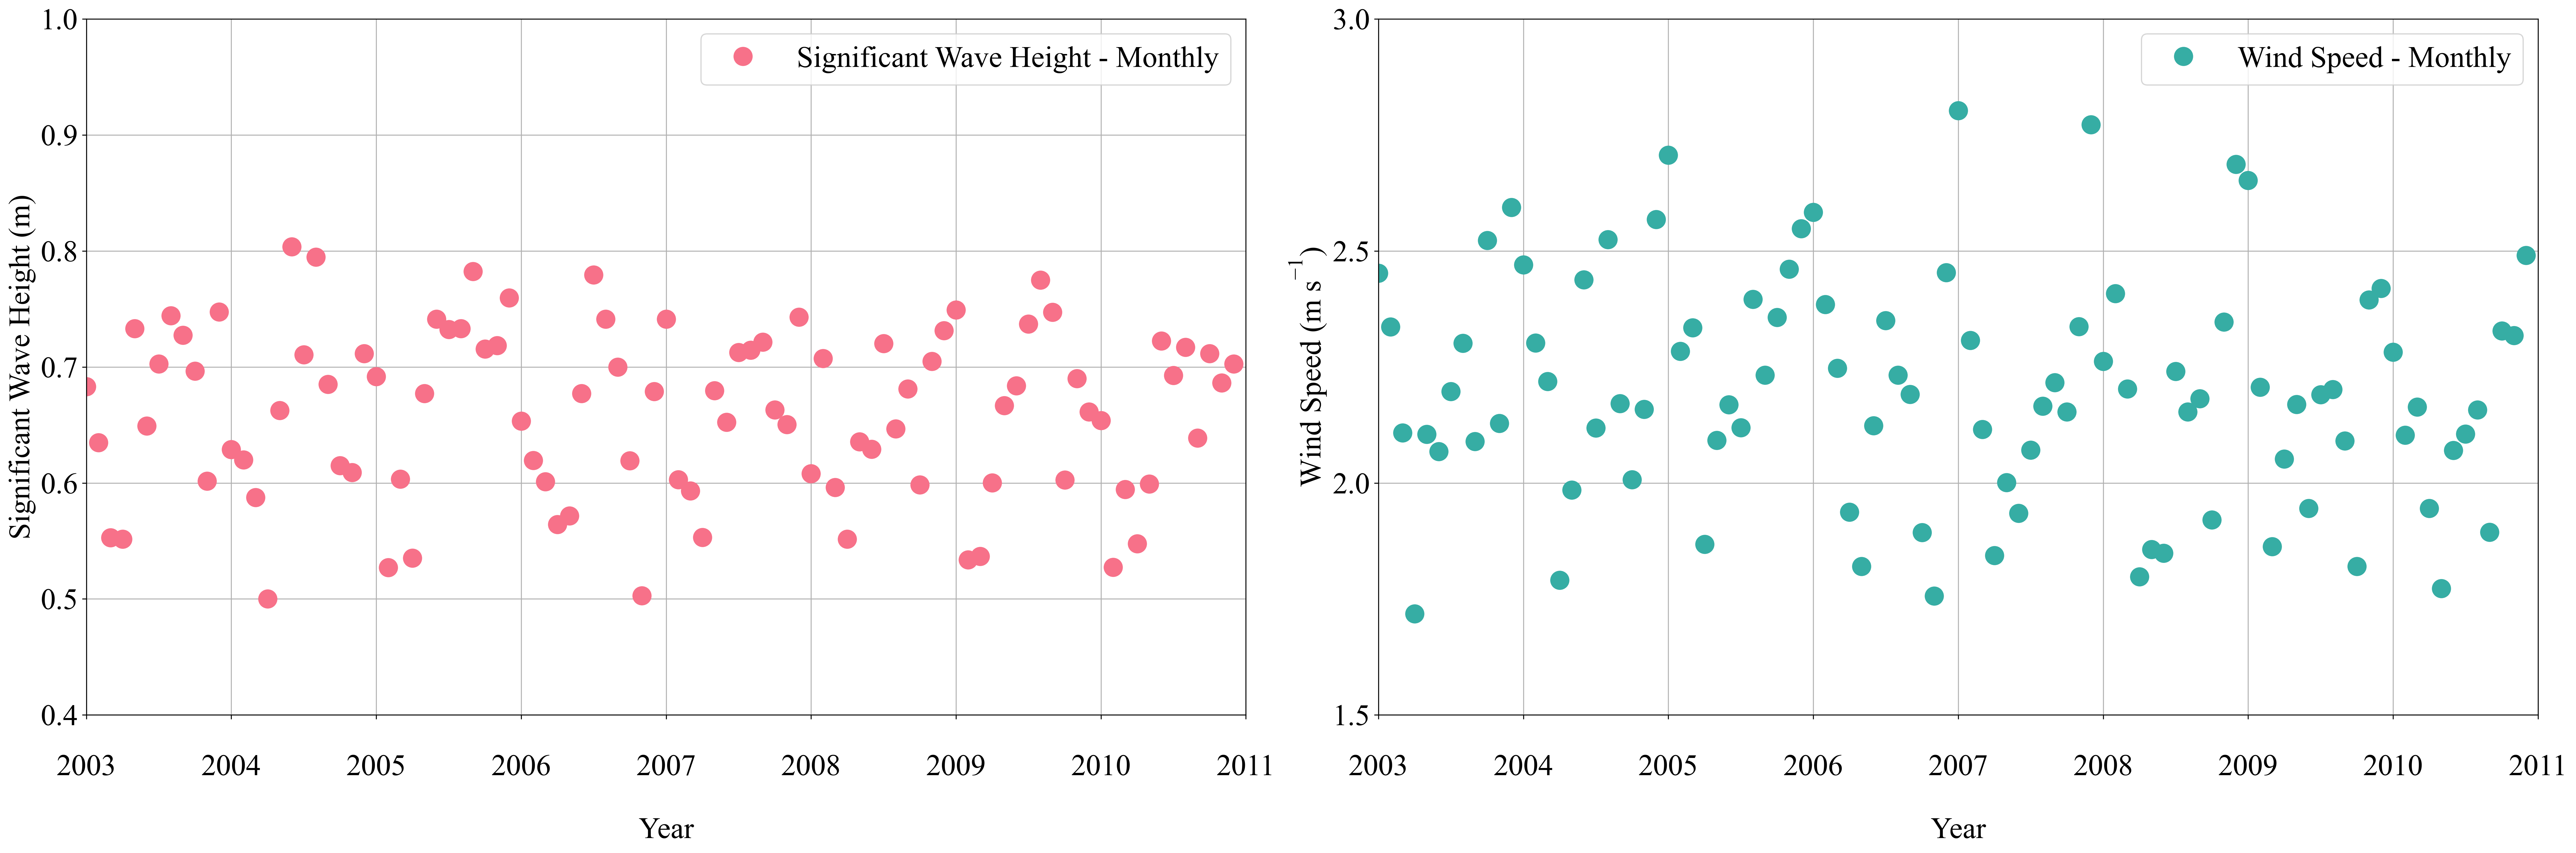

In [13]:
# Plot Time-Series

parameters = ['SWH', 'WS']

y_labels = ['Significant Wave Height', 'Wind Speed']

y_labels_unit = ['Significant Wave Height (m)', 'Wind Speed (m $\mathregular{s^{-1}}$)']

y_limits = [(0.4, 1), (1.5, 3)]

y_ranges = [7, 4]

colors = sns.color_palette('husl', n_colors=len(parameters))

fig, axs = plt.subplots(1, 2, figsize=(30, 10), dpi=300)

xticks = np.arange(0, 97, 12)
xticklabels = ['\n2003', '\n2004', '\n2005', '\n2006', '\n2007', '\n2008', '\n2009', '\n2010', '\n2011']

axs = axs.flatten()

for i, parameter in enumerate(parameters):
    ax = axs[i]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=25)
    ax.set_xlabel('\nYear', fontsize=25)
    ax.set_ylim(y_limits[i])
    ax.set_xlim([0, 96]) 
    y_ticks = np.linspace(*y_limits[i], num=y_ranges[i])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{ytick:.1f}' for ytick in y_ticks], fontsize=25)  
    ax.set_ylabel(y_labels_unit[i], fontsize=25)
        
    monthly_ts = monthly_time_series[parameter]
    
    ax.plot(np.arange(0, 96), monthly_ts, 'o', markersize=15, color=colors[i], label=y_labels[i] + ' - Monthly', alpha=1)
    
    ax.legend(loc='best', fontsize=25)
    
    ax.grid(True)
    
fig.tight_layout()

plt.show()
# fig.savefig('Time-series.png')

In [14]:
parameters = ['SWH', 'WS']

for param in parameters:
    series = monthly_time_series[param]
    print(f"Parameter: {param}")
    print(f"Mean: {series.mean():.3f}")
    print(f"Standard Deviation: {series.std():.3f}")
    print(f"Maximum: {series.max():.3f}")
    print(f"Minimum: {series.min():.3f}")
    print()

Parameter: SWH
Mean: 0.661
Standard Deviation: 0.073
Maximum: 0.804
Minimum: 0.500

Parameter: WS
Mean: 2.200
Standard Deviation: 0.244
Maximum: 2.803
Minimum: 1.718

